## Code

In [1]:
import os
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as pl
import numpy as np

from environment import load_condensed_artefacts
from synthetic import check_model

%matplotlib inline
%config InlineBackend.figure_format='retina'

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
s_ = {
    # Font size attributes
    'font.size'               : 12,
    'axes.titlesize'          : 'medium',
    'axes.labelsize'          : 'medium',
    'axes.labelweight'        : 'normal',
    'axes.titleweight'        : 'bold',
    'axes.titlelocation'      : 'left',
    
    # Font size attributes
    'xtick.labelsize'         : 'medium',
    'ytick.labelsize'         : 'medium',

    # Turn on minor ticks, top and right axis ticks, and change the direction to 'in'
    'xtick.top'               : 'True',
    'ytick.right'             : 'True',
    'xtick.minor.visible'     : 'True',
    'ytick.minor.visible'     : 'True',
    'ytick.direction'         : 'in',
    'xtick.direction'         : 'in',

    # Increase the major and minor tick-mark lengths
    'xtick.major.size'        : 4,  # default 3.5
    'ytick.major.size'        : 4,  # default 3.5
    'xtick.minor.size'        : 2,  # default 2
    'ytick.minor.size'        : 2,  # default 2

    # Change the tick-mark and axes widths, as well as the widths of plotted lines
    'xtick.major.width'       : 0.8,  # default 0.8
    'ytick.major.width'       : 0.8,  # default 0.8
    'xtick.minor.width'       : 0.8,  # default 0.6
    'ytick.minor.width'       : 0.8,  # default 0.6
    'axes.linewidth'          : 0.8,  # default 0.8

    # Increase the padding between the ticklabels and the axes
    'xtick.major.pad'         : 4,  # default 3.5
    'ytick.major.pad'         : 4,  # default 3.5
    'xtick.minor.pad'         : 4,  # default 3.5
    'ytick.minor.pad'         : 4,  # default 3.5

    # Turn off the legend frame
    'legend.frameon'          : 'False'
}
pl.style.use(s_)  # --> matplotlib.rcParams

### Load artefact

In [3]:
bdata, z, f = load_condensed_artefacts(os.path.join('../out', 'experiment_condensed.hdf5'), jaxify=False)

Loaded successfully condensed artefacts in file experiment_condensed.hdf5


### Visualise environment

In [4]:
N = bdata['N']
J = bdata['J']

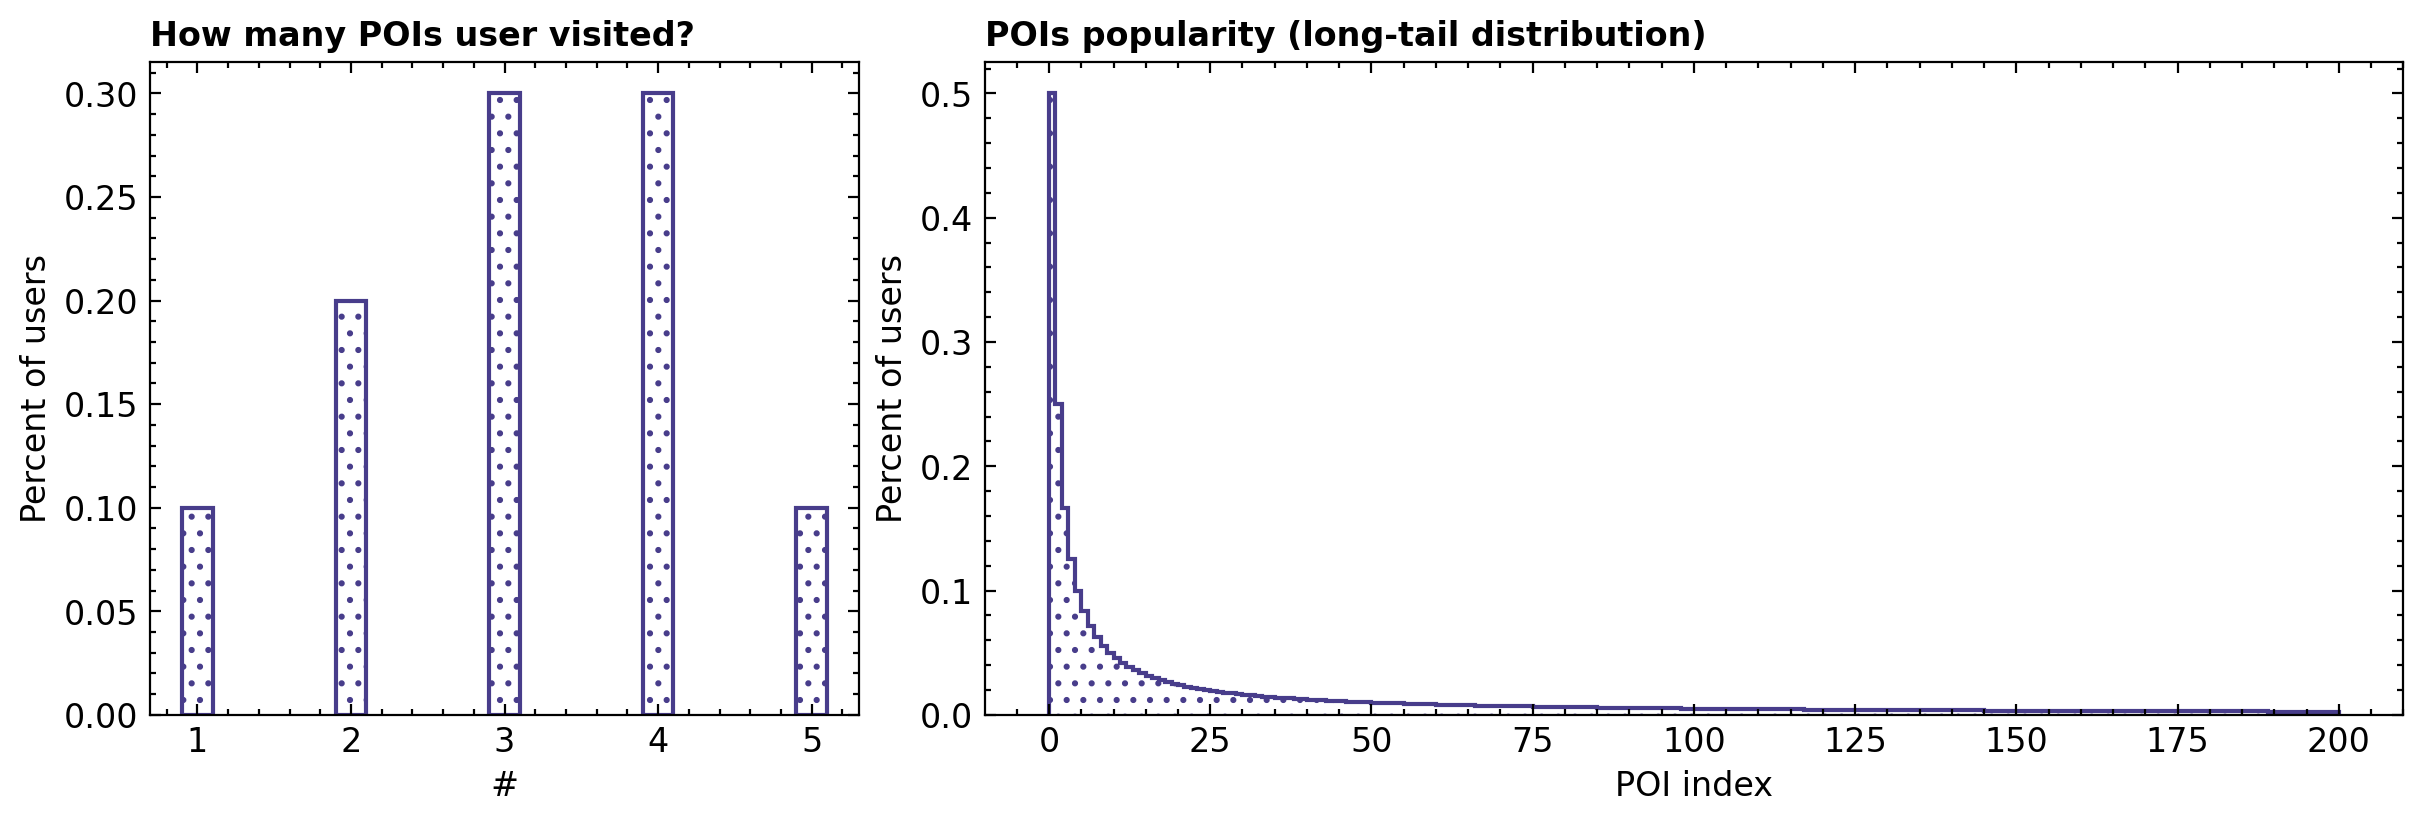

In [5]:
fg = pl.figure(figsize=(12, 4), layout='constrained')

gs = gridspec.GridSpec(
    1, 3,
    figure=fg,
)

ax = fg.add_subplot(gs[0,0:1])
bx = fg.add_subplot(gs[0,1: ])

# -----------------------------------------------------------------------------

# Consumption pattern selected based on apriori assumption and time required to
# visit every POI in the simulated universe of POIs

color = 'darkslateblue'

ax.bar(
    list(bdata['T_pmi']),
    list(bdata['T_pmf']), width=0.2, edgecolor=color, facecolor='none', alpha=1, lw=1.5, hatch='..',
)
ax.set_xlabel('#')
ax.set_ylabel('Percent of users')
ax.set_title('How many POIs user visited?')

# -----------------------------------------------------------------------------

# The popularity curve takes the form of a power law, with the head including a
# few very popular POIs and a long tail comprising the remaining POIs

bx.stairs(
    list(bdata['J_pmf']),
    list(bdata['J_pmi']) + [bdata['J']], color=color, alpha=1, lw=1.5, hatch='..',
)
bx.set_xlabel('POI index')
bx.set_ylabel('Percent of users')
bx.set_title('POIs popularity (long-tail distribution)')

pl.savefig('pop.png', dpi=250)

pl.show()

[0.06141852 0.05549016]


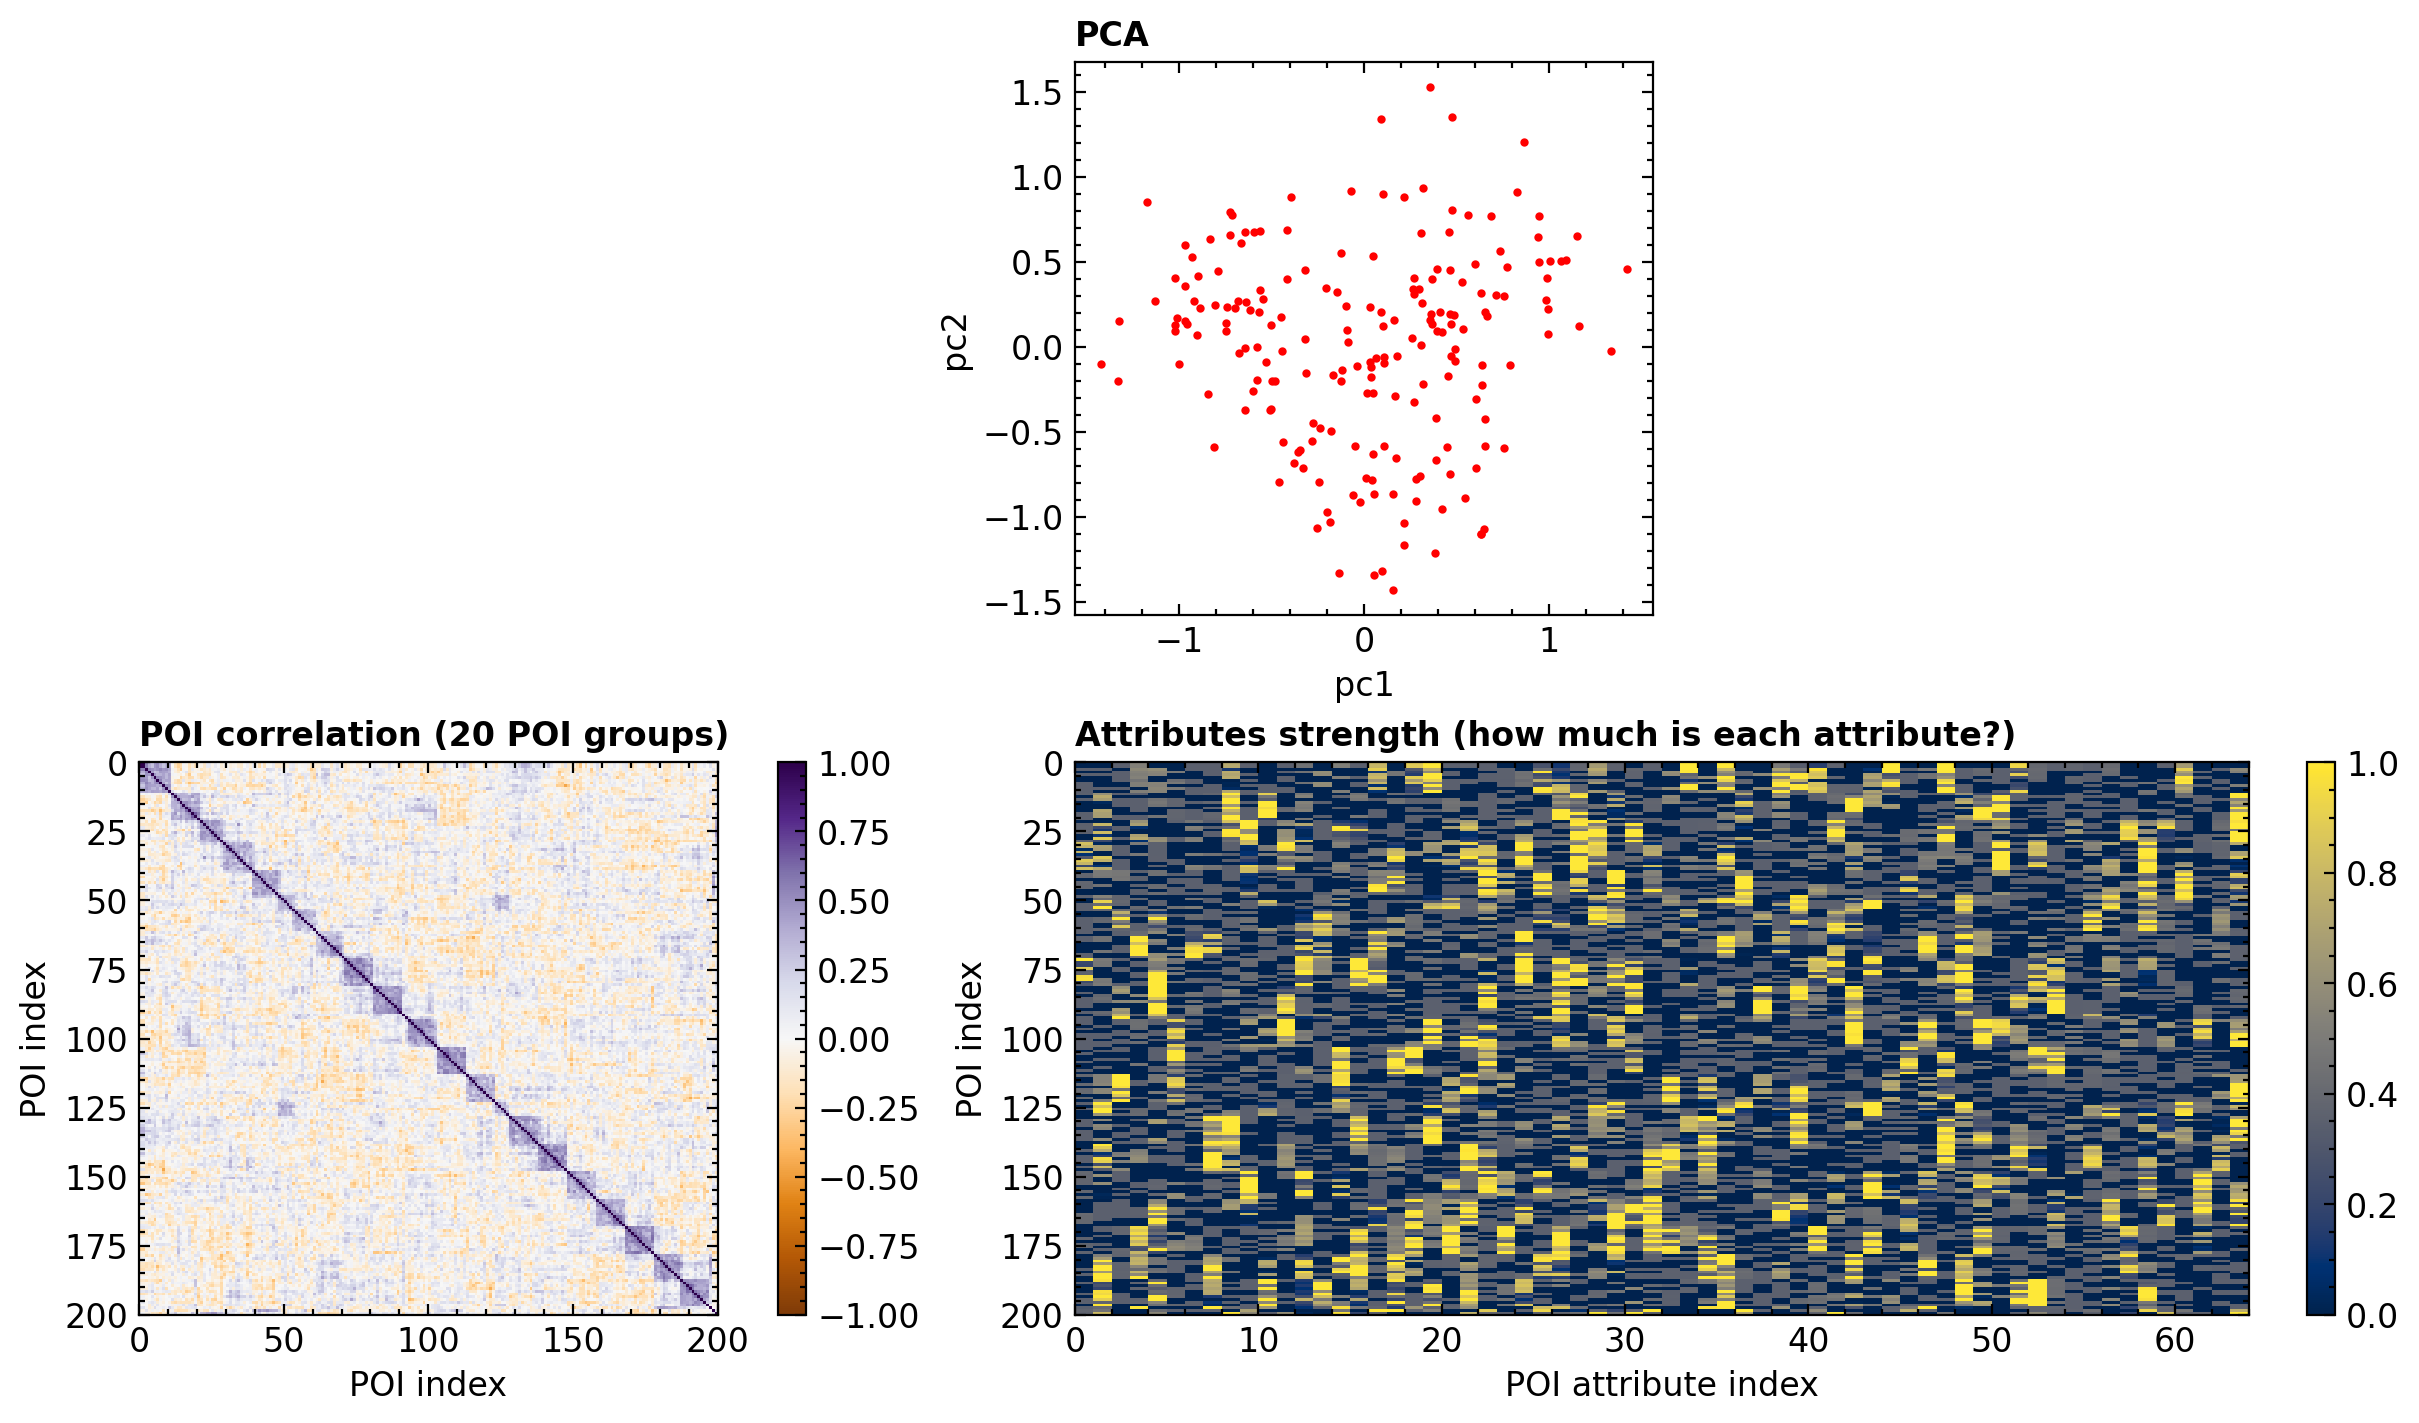

In [6]:
from sklearn.decomposition import PCA


h, temp, seen = [f[0]], f[0], {0}

while len(seen) < J:  # order items, starting from the most popular
    best_k = np.inf
    best_s = np.inf
    for k in range(J):
        if k in seen:
            continue
        else:
            s = np.linalg.norm(temp-f[k])
            if s < best_s:
                best_k = k
                best_s = s
    h, temp, seen = h+[temp], f[best_k], seen|{best_k}

g = np.array(h)  # the same as `f` defined before, but with groups aggregations


# -----------------------------------------------------------------------------

fg = pl.figure(figsize=(12, 7), layout='constrained')

gs = gridspec.GridSpec(
    2, 3,
    figure=fg,
)

ax = fg.add_subplot(gs[0,1:2])
bx = fg.add_subplot(gs[1,0:1])
cx = fg.add_subplot(gs[1,1: ], sharey=[bx, bx.invert_yaxis()][0])

# The first 2 PCA components of defined items vectors. There are correlation in
# between items within the same cluster. Once can see that similar items (POIs)
# condense toghether. At the same time, separation is not perfect, because PCA
# losses a lot of information when try to explain data with only two components

# -----------------------------------------------------------------------------

pca = PCA(n_components=2, svd_solver='full', whiten=False).fit(g)
f2d = pca.transform(g)
print(pca.explained_variance_ratio_)

ax.plot(f2d[:,0], f2d[:,1], color='r', marker='o', linestyle='none', markersize=2)
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')

# -----------------------------------------------------------------------------

pcm = bx.pcolormesh(np.corrcoef(g), cmap='PuOr', vmin=-1, vmax=1, shading='flat')
fg.colorbar(pcm, ax=bx)
bx.set_xlabel('POI index')
bx.set_ylabel('POI index')

# -----------------------------------------------------------------------------

pcm = cx.pcolormesh(g, cmap='cividis', vmin=0, vmax=1, shading='flat')
fg.colorbar(pcm, ax=cx)
cx.set_xlabel('POI attribute index')
cx.set_ylabel('POI index')

# -----------------------------------------------------------------------------

ax.set_title('PCA')
bx.set_title('POI correlation (20 POI groups)')
cx.set_title('Attributes strength (how much is each attribute?)')

pl.show()

In [7]:
p_fit, ui_matrix = check_model(param_tree={'z': z}, f=f, bdata=bdata)

estimated over a population of 10000 users KL: QP_loss=1.076077 PQ_loss=0.429662
chi2_loss=0.428777


In [8]:
import numba as nb


@nb.njit
def pool(x, size=4):  # max pool for visualisation purposes only
    
    z = np.zeros_like(x)
    n = x.shape[0]  # number of items
    m = x.shape[1]  # number of users
    
    for i in range(n):
        for j in range(0, m-size, size):
            z[i,j:j+size] = np.max(x[i,j:j+size])
    
    return z

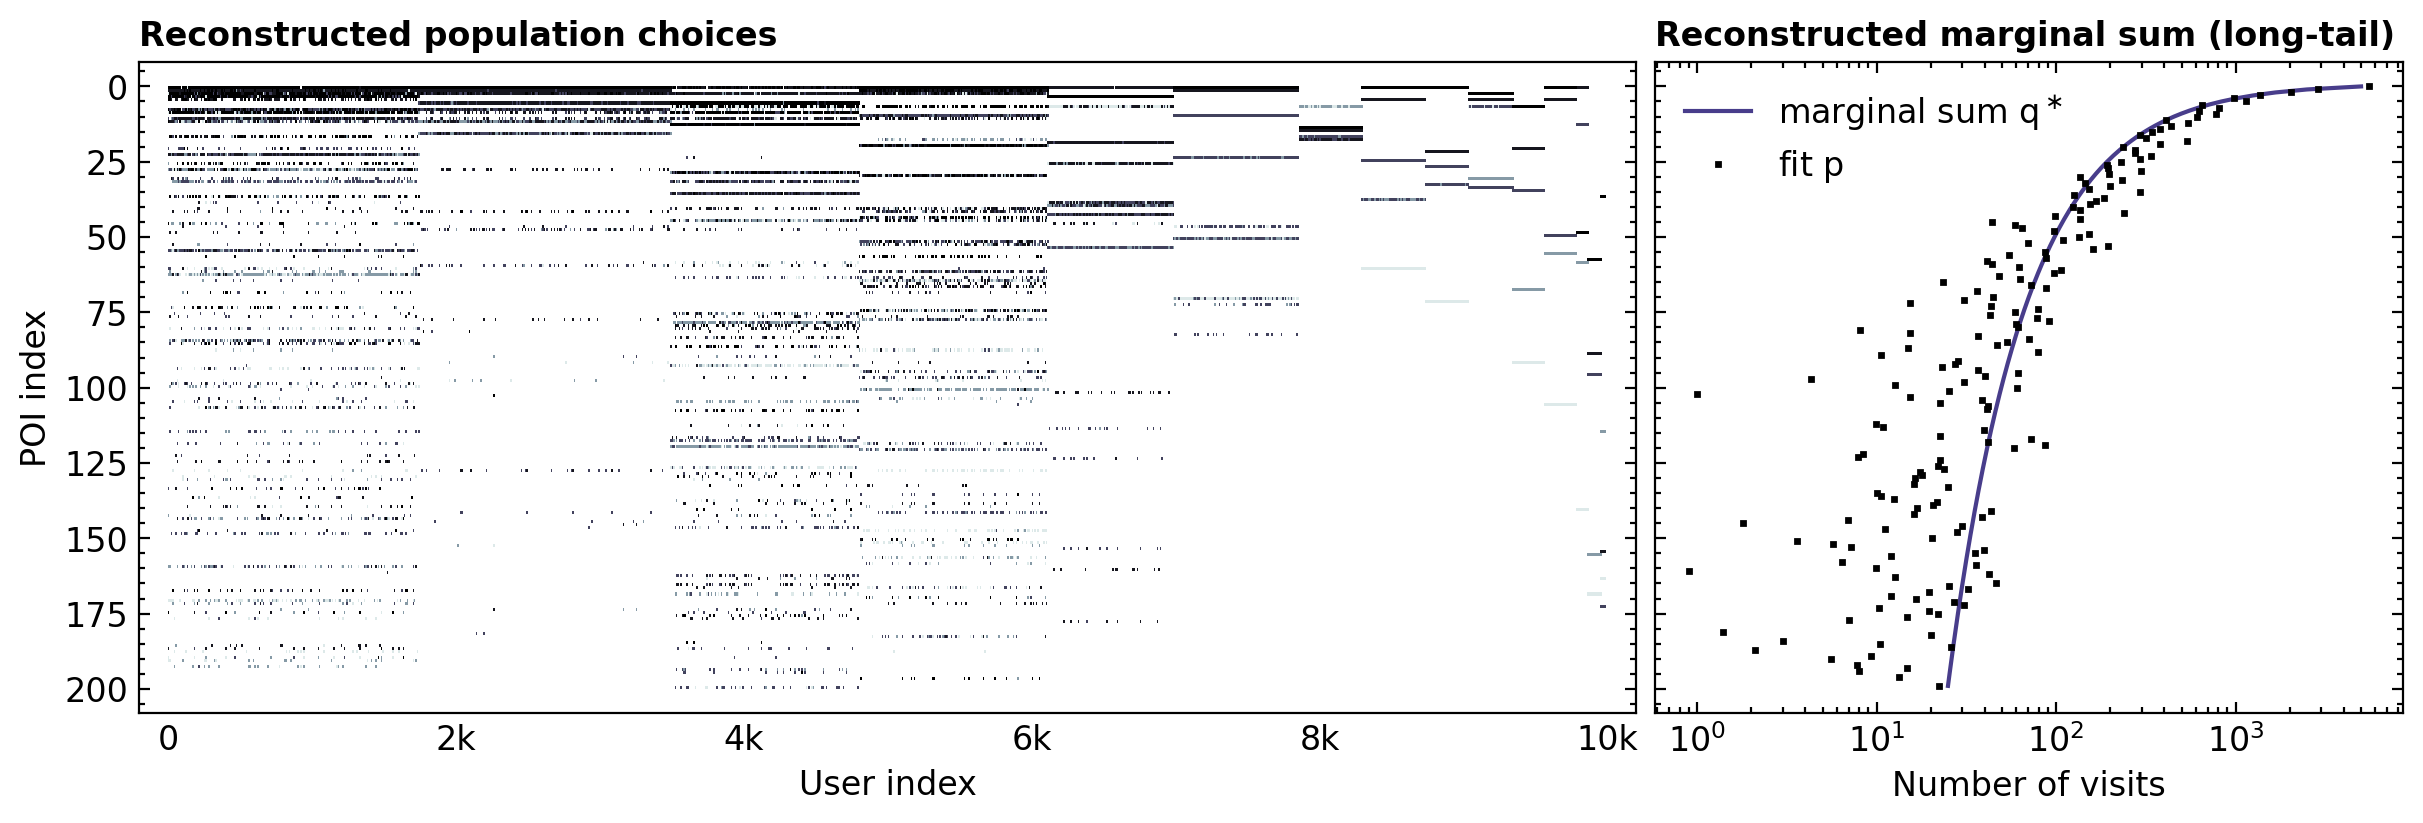

In [9]:
fg = pl.figure(figsize=(12, 4), layout='constrained')

gs = gridspec.GridSpec(
    1, 3,
    figure=fg,
)

ax = fg.add_subplot(gs[0,0:2], xlim=(-200, 10000+200), ylim=(200+8, -8))
bx = fg.add_subplot(gs[0,2: ], sharey=ax)
ax.tick_params(axis='x', which='both', bottom=0, top=0)
bx.tick_params(axis='y', which='both', labelleft=False)

# -----------------------------------------------------------------------------

y = pool(
    ui_matrix.T, size=10,
)
ax.pcolormesh(y, cmap='bone_r', shading='flat', edgecolors='none', aa=0, snap=1, alpha=1, rasterized=True)

ax.set_xlabel('User index')
ax.set_ylabel('POI index')
ax.set_xticks(ticks=[0,2000,4000,6000,8000,9999], labels=['0','2k','4k','6k','8k','10k'], rotation=0)

# -----------------------------------------------------------------------------

bx.plot(bdata['N']*bdata['J_pmf'], np.arange(bdata['J']), color=color, lw=1.5)
bx.plot(bdata['N']*p_fit, np.arange(bdata['J']), c='k', marker='s', ms=1.5, linestyle='none')
bx.set_xlabel('Number of visits')
bx.set_xscale('log')
bx.legend([r'marginal sum $\mathrm{q^\ast}$',r'fit $\mathrm{p}$'], loc='upper left')

# -----------------------------------------------------------------------------

ax.set_title('Reconstructed population choices')
bx.set_title('Reconstructed marginal sum (long-tail)')

pl.savefig('fit.png', dpi=250)
pl.show()

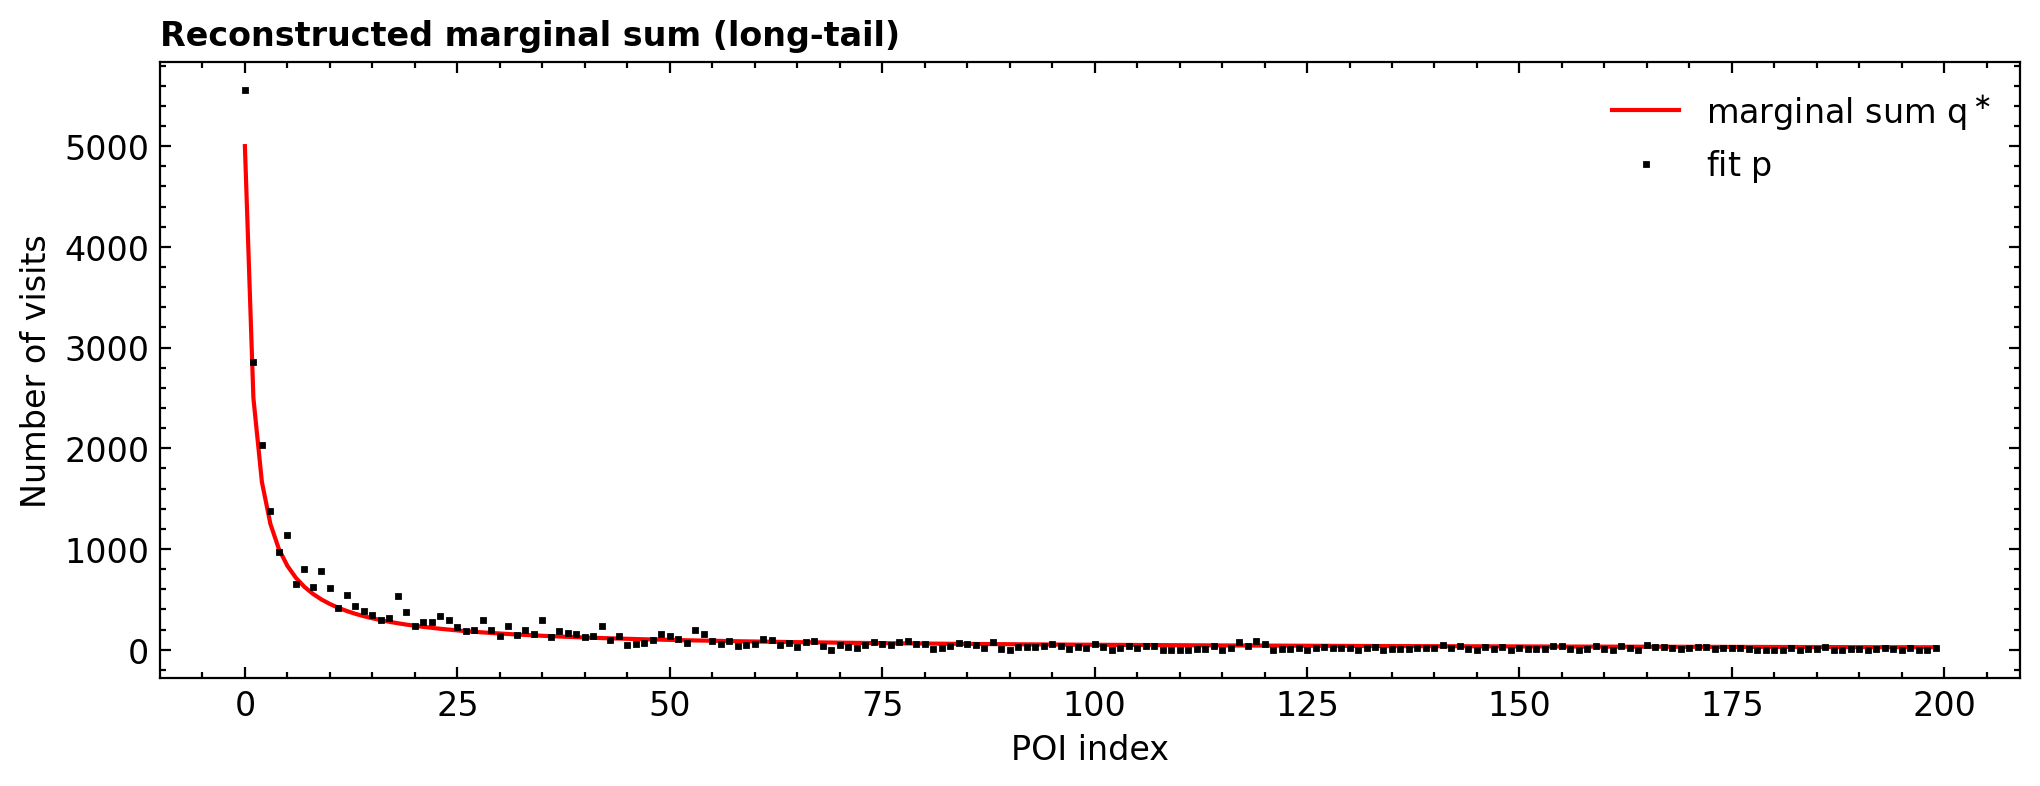

In [10]:
fig, ax = pl.subplots(figsize=(12, 4))  # same as above, but linear x-axis

ax.plot(bdata['N']*bdata['J_pmf'], c='r')
ax.plot(bdata['N']*p_fit, c='k', marker='s', markersize=1.5, linestyle='none')
ax.set_xlabel('POI index')
ax.set_ylabel('Number of visits')
ax.set_title('Reconstructed marginal sum (long-tail)')
ax.legend([r'marginal sum $\mathrm{q^\ast}$',r'fit $\mathrm{p}$'], loc='upper right')
pl.show()

In [11]:
g_corr = np.corrcoef(g)
z_corr = np.corrcoef(z)

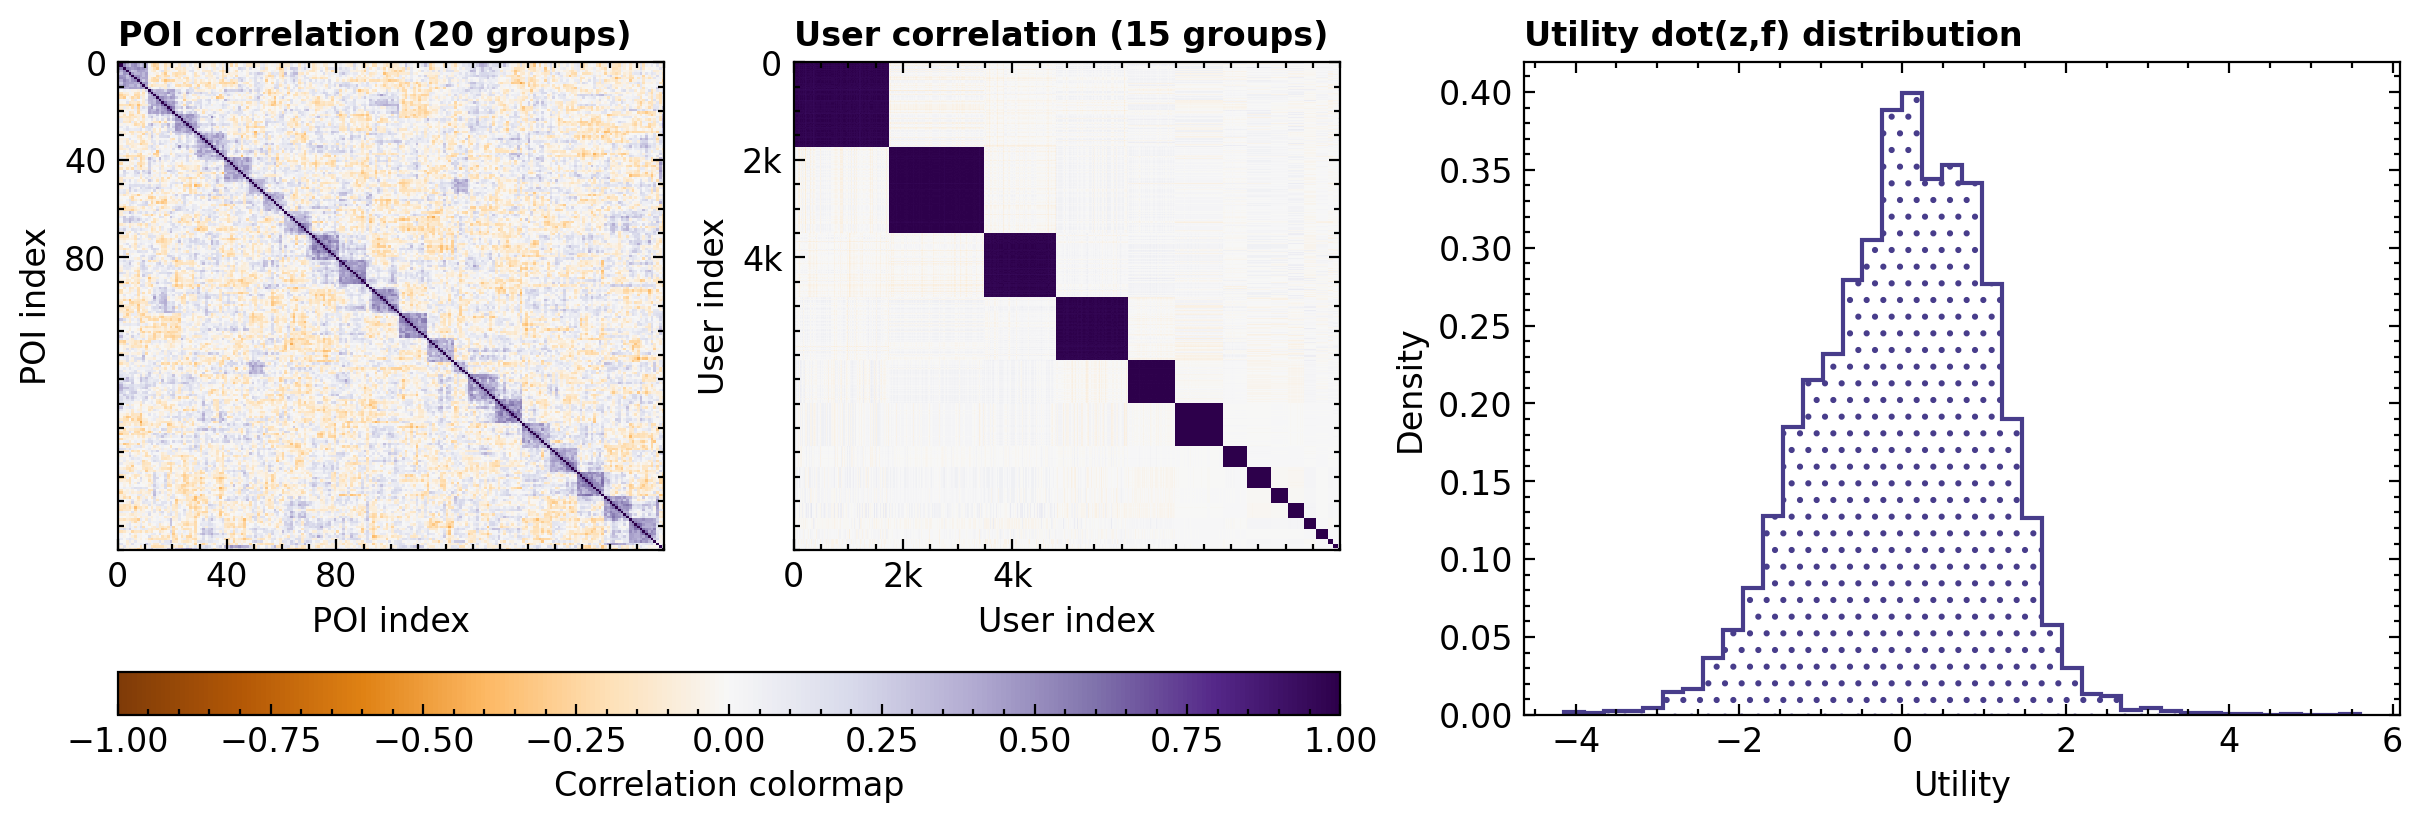

In [12]:
fg = pl.figure(figsize=(12, 4), layout='constrained')

gs = gridspec.GridSpec(
    5, 7,
    figure=fg,
)

ax = fg.add_subplot(gs[0:4,0:2]); ax.invert_yaxis()
bx = fg.add_subplot(gs[0:4,2:4]); bx.invert_yaxis()
cx = fg.add_subplot(gs[0:5,4: ])
xx = fg.add_subplot(gs[4:5,0:4])

# -----------------------------------------------------------------------------

cmap = 'PuOr'

pcm = ax.pcolormesh(g_corr, cmap=cmap, vmin=-1, vmax=1, shading='flat', rasterized=True)
ax.set_xlabel('POI index')
ax.set_ylabel('POI index')
ax.set_xticks(ticks=[0,40,80])
ax.set_yticks(ticks=[0,40,80])

# -----------------------------------------------------------------------------

pcm = bx.pcolormesh(z_corr, cmap=cmap, vmin=-1, vmax=1, shading='flat', rasterized=True)
bx.set_xlabel('User index')
bx.set_ylabel('User index')
bx.set_xticks(ticks=[0,2000,4000], labels=['0','2k','4k'])
bx.set_yticks(ticks=[0,2000,4000], labels=['0','2k','4k'])

cbar = fg.colorbar(pcm, cax=xx, fraction=1, shrink=0.5, aspect=20, location='bottom', label='Correlation colormap')

# -----------------------------------------------------------------------------

vals, bins = np.histogram(np.matmul(z, f.T).ravel(), bins=40)
norm = np.sum(vals*np.diff(bins))

cx.stairs(
    vals/norm,
    bins, color=color, alpha=1, lw=1.5, hatch='..',
)
cx.set_xlabel('Utility')
cx.set_ylabel('Density')
cx.set_title('')

# -----------------------------------------------------------------------------

ax.set_title('POI correlation (20 groups)')
bx.set_title('User correlation (15 groups)')
cx.set_title('Utility dot(z,f) distribution')

pl.savefig('uti.png', dpi=250)

pl.show()